In [25]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [26]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')
    
print(device)
device =  torch.device('cpu')

cuda:3


In [27]:
print(device)

cpu


In [28]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [29]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.467275,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.650008,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000271,0.000021,11.650008,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000278,0.000021,11.394500,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000185,0.000024,11.123803,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35370,21,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000282,0.000020,6.772435,6.773650,213,23,6.773650,6.773650,12.204,12.204
35371,22,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000191,0.000024,5.995879,5.996763,213,23,5.996763,5.996763,12.204,12.204
35372,23,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000102,0.000032,5.229508,5.230045,213,23,5.230045,5.230045,12.204,12.204
35373,24,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000013,0.000037,4.467800,4.468109,213,23,4.468109,4.468109,12.204,12.204


In [30]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [31]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [32]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'temp_heat00', 'diffusivity']
output_columns = ['temp_diff01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [33]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (21225, 15), X_test: (14150, 15)
y_train: (21225, 1), y_test: (14150, 1)


In [34]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [35]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [36]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [37]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500


optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [38]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=15, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [39]:
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

# mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
# std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

# mean_out = torch.tensor(output_mean).to(device)
# std_out = torch.tensor(output_std).to(device)
    
# def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
#     # de-normalise data
#     diff = diff * std_diff + mean_diff

#     # INPUT DATA FROM PREVIOUS MODULE
#     t = temp * std_temp + mean_temp # temperature profile from previous module output

#     # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     j = len(t)
#     y = torch.zeros((len(t), len(t)), dtype=torch.float64).to(device)

#     alpha = (dt/dx**2) * diff

#     az = - alpha # subdiagonal
#     bz = 2 * (1 + alpha) # diagonal
#     cz = - alpha # superdiagonal

#     bz[0] = 1
#     az[len(az)-2] = 0
#     bz[len(bz)-1] = 1
#     cz[0] = 0

#     az = az[1:,:]
#     cz = cz[:-1,:]

#     y = torch.diag(bz[:, 0])+torch.diag(az[:, 0],-1)+torch.diag(cz[:, 0],1) #slightly efficient way of computing the diagonal matrices
#     y[j-1, j-1] = 1
    
#     mn = torch.zeros_like(t)  
#     mn[0] = t[0]
#     mn[len(mn)-1] = t[len(t)-1]
    
#     mn[1:j-1] = alpha[1:j-1,0]*t[:j-2] + 2 * (1 - alpha[1:j-1,0])*t[1:j-1] + alpha[1:j-1,0]*t[1:j-1] #is be same as the loop
    
#     # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
#     proj = torch.linalg.solve(y, mn)

#     mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
#     proj = (proj-mean_out)/std_out

#     proj = proj.to(torch.double)
#     return proj

In [40]:
mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [41]:
# diffusivity_true = torch.tensor(X_train[:,input_column_ix[13]], device=device).unsqueeze(1)
# temp_heat_true = torch.tensor(X_train[:,input_column_ix[14]], device=device)#.unsqueeze(1)
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)
# print(mean_diff, std_diff)

# pred = implicit_diffusion(diff=diffusivity_true, 
#                           temp=temp_heat_true)

# print(torch.mean((pred-y_train)**2))

In [42]:
# time = 20
# # print(pred[25*time:25*(time+1)])
# # print(y_train[25*time:25*(time+1)])
# print((pred[25*time:25*(time+1)]-y_train[25*time:25*(time+1)]).abs())

In [43]:
# # test if the Crank-Nicholson scheme works

# temp = torch.rand(5,1).to(device)
# diff = torch.rand(5,1).to(device)
# print(temp), print(diff)
# implicit_diffusion(diff, temp, input_mean, input_std,
#                                  output_mean, output_std)

In [44]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        
        # get temperature input
        temp_input = x[:,13]
        
        optimizer.zero_grad()
        proj = model(x)
        
        pred = implicit_diffusion(proj, temp_input)
#         pred = pred.to(dtype=torch.float32)
        
#         print(pred.mean(), y.mean(), pred.std(), y.std())
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            temp_input = x[:,13] #* std + mean

            optimizer.zero_grad()
            proj = model(x)

            pred = implicit_diffusion(proj, temp_input)

            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 2/1000 [00:00<04:00,  4.16it/s]

Epoch : 0, Train_loss: 0.012964083220471035, Test_loss: 2.6567366512608713e-05


  5%|▌         | 52/1000 [00:09<03:10,  4.98it/s]

Epoch : 50, Train_loss: 1.3861857951269485e-05, Test_loss: 2.13462962013485e-05


 10%|█         | 102/1000 [00:17<02:32,  5.87it/s]

Epoch : 100, Train_loss: 5.900962419631965e-06, Test_loss: 1.644835150121556e-05


 15%|█▌        | 152/1000 [00:25<02:30,  5.62it/s]

Epoch : 150, Train_loss: 4.187519121759661e-06, Test_loss: 1.2985272132937097e-05


 20%|██        | 201/1000 [00:33<02:26,  5.47it/s]

Epoch : 200, Train_loss: 3.448864741916292e-06, Test_loss: 9.989646590232345e-06


 25%|██▌       | 252/1000 [00:41<02:09,  5.79it/s]

Epoch : 250, Train_loss: 3.384701926734124e-06, Test_loss: 7.630859984904722e-06


 30%|███       | 302/1000 [00:50<02:11,  5.29it/s]

Epoch : 300, Train_loss: 3.259992168254526e-06, Test_loss: 6.063833620828518e-06


 35%|███▌      | 352/1000 [00:59<02:18,  4.67it/s]

Epoch : 350, Train_loss: 2.9258170570756192e-06, Test_loss: 5.356807082534942e-06


 40%|████      | 402/1000 [01:07<01:47,  5.58it/s]

Epoch : 400, Train_loss: 2.880466452511014e-06, Test_loss: 5.239650931798678e-06


 45%|████▌     | 452/1000 [01:15<01:38,  5.59it/s]

Epoch : 450, Train_loss: 2.7877489401362254e-06, Test_loss: 5.524900067636432e-06


 50%|█████     | 502/1000 [01:24<01:33,  5.31it/s]

Epoch : 500, Train_loss: 2.719144070149262e-06, Test_loss: 5.243689565759269e-06


 55%|█████▌    | 551/1000 [01:33<01:22,  5.41it/s]

Epoch : 550, Train_loss: 2.7286757709920164e-06, Test_loss: 5.497548045241274e-06


 60%|██████    | 602/1000 [01:42<01:16,  5.21it/s]

Epoch : 600, Train_loss: 2.910873728400144e-06, Test_loss: 5.591424852961306e-06


 65%|██████▌   | 652/1000 [01:50<01:01,  5.66it/s]

Epoch : 650, Train_loss: 2.58861725073571e-06, Test_loss: 5.762653260414178e-06


 70%|███████   | 702/1000 [01:59<00:55,  5.35it/s]

Epoch : 700, Train_loss: 2.5652609203709953e-06, Test_loss: 5.911827990227417e-06


 75%|███████▌  | 752/1000 [02:07<00:43,  5.66it/s]

Epoch : 750, Train_loss: 2.790551134653056e-06, Test_loss: 6.006820315936541e-06


 80%|████████  | 802/1000 [02:15<00:38,  5.09it/s]

Epoch : 800, Train_loss: 2.5999176345563186e-06, Test_loss: 6.222418869583635e-06


 85%|████████▌ | 852/1000 [02:23<00:25,  5.76it/s]

Epoch : 850, Train_loss: 2.5038822596715446e-06, Test_loss: 6.386471720058277e-06


 90%|█████████ | 902/1000 [02:33<00:24,  3.96it/s]

Epoch : 900, Train_loss: 2.551841574090345e-06, Test_loss: 6.5331381316961295e-06


 95%|█████████▌| 952/1000 [02:43<00:09,  4.82it/s]

Epoch : 950, Train_loss: 2.902642424115501e-06, Test_loss: 6.664244976188153e-06


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


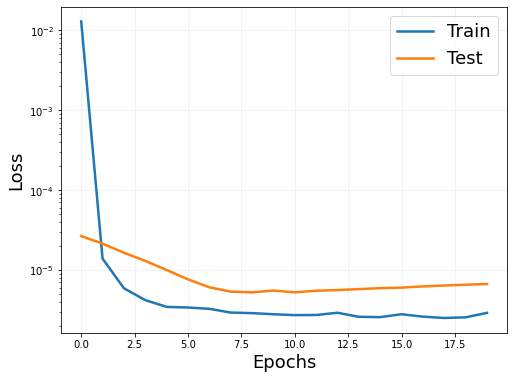

In [45]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [46]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        
        temp_input = x[:,13]
        proj = model(x)
        pred = implicit_diffusion(proj, temp_input)        
        pred = pred.to(dtype=torch.float32)
        
#         print(torch.mean((pred-y)**2))
#         print(y.shape)
        
        y = y * std + mean
        pred = pred * std + mean
        
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_, pred_)
    l2_error_temp = l2_error(y_, pred_)
    return rmse_temp, l2_error_temp

In [47]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.015691307955652278
L2 Error  of Temp: 0.0010806718790670568


In [48]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.010198850908775169
L2 Error  of Temp: 0.0007967388357821287


# Saving Model

In [49]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [50]:
output_mean

array([11.34604205])